Epoch 1/40


/var/folders/7z/lym9xm5d691_v7b014fc_tvm0000gn/T/ipykernel_58187/1690349045.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.sort_values("timestamp").set_index("timestamp").asfreq("H")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1030/1030 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 0.0032 - val_loss: 6.1501e-04 - learning_rate: 0.0010
Epoch 2/40
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - loss: 7.5370e-04 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 3/40
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - loss: 5.8426e-04 - val_loss: 6.9783e-04 - learning_rate: 0.0010
Epoch 4/40
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - loss: 5.0243e-04 - val_loss: 7.5674e-04 - learning_rate: 0.0010
Epoch 5/40
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - loss: 3.8470e-04 - val_loss: 3.9389e-04 - learning_rate: 5.0000e-04
Epoch 6/40
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - loss: 3.5542e-04 - val_loss: 4.6541e-04 - learning_rate: 5.0000e-04
Epoch 7/40
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - loss: 3.2197e-04 - val_loss: 0.0020 - learning_rate: 5.0000e-04
Epoch 8/40
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 79s 77ms/step - loss: 3.0950e-04 - val_loss: 0.0032 - learning_rate: 5.0000e-04
Epoch 9/40
1030/1030 ━━━━━━━━━━━━━━

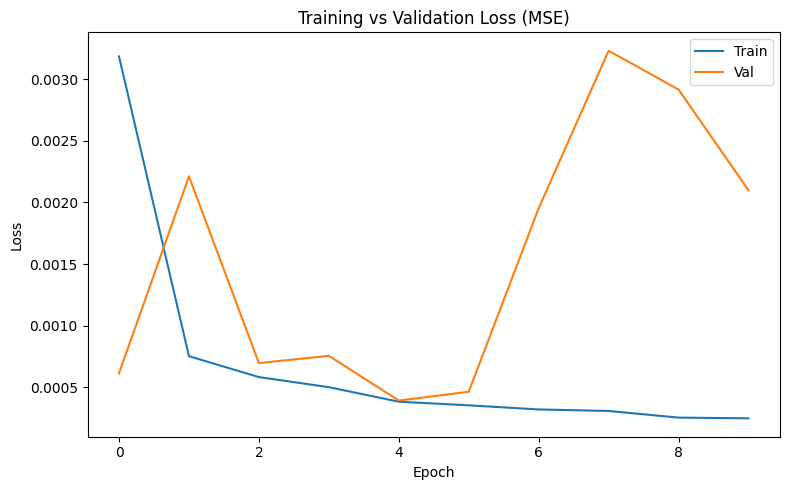

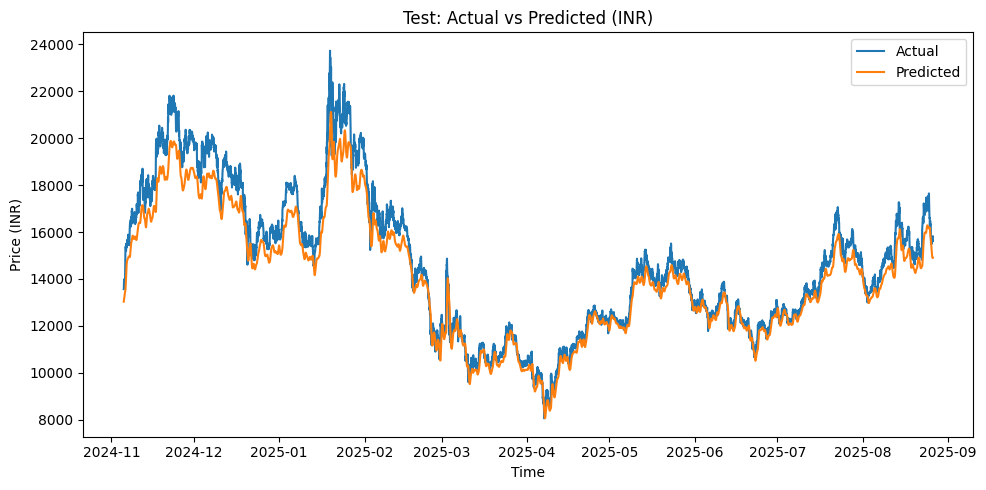

/var/folders/7z/lym9xm5d691_v7b014fc_tvm0000gn/T/ipykernel_58187/1690349045.py:111: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq="H")


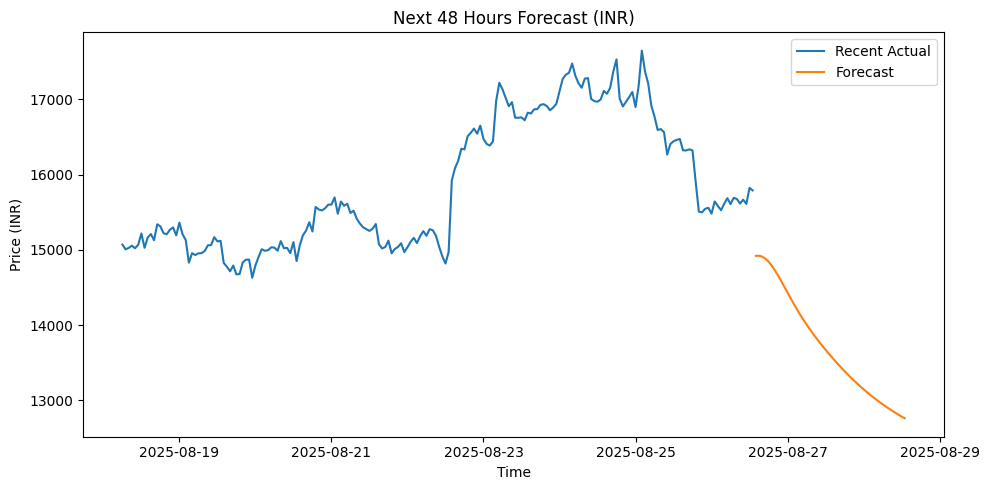

In [6]:
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- CONFIG ---
CSV_PATH = "/Users/vanshagarwal/Documents/GitHub/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_August_2025/Milestone1/crypto hourly data/SOL_USD_historical_hourly.csv"   # replace with your file path
RATE_INR_PER_USD = 83.0
LOOKBACK = 96
FORECAST_STEPS = 48
np.random.seed(42); tf.random.set_seed(42)

# --- Load/Preprocess ---
df = pd.read_csv(CSV_PATH)
df["timestamp"] = pd.to_datetime(df["TIMESTAMP"], unit="s", utc=True)
df = df.sort_values("timestamp").set_index("timestamp").asfreq("H")
df["close_usd"] = df["CLOSE"].interpolate(method="time").ffill().bfill()
df["close_inr"] = df["close_usd"] * RATE_INR_PER_USD
values = df[["close_inr"]].values.astype("float32")

# scale 0–1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# make sequences
X, y = [], []
for i in range(len(scaled) - LOOKBACK):
    X.append(scaled[i:i+LOOKBACK, 0])
    y.append(scaled[i+LOOKBACK, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# chronological split (70% train, 15% val, 15% test)
n = len(X); n_test = int(0.15*n); n_val = int(0.15*n); n_train = n - n_val - n_test
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
t = df.index.values[LOOKBACK:]
t_test = t[n_train+n_val:]

# --- Model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK,1),
         kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
 
    Dropout(0.4),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

# callbacks
coin = "SOL"      # e.g. SOL, BTC, ETH
interval = "1h" 
ckpt = f"{coin.lower()}_{'hourly' if interval=='1h' else 'daily'}_lstm.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint(ckpt, monitor="val_loss", save_best_only=True)
]

# --- Train ---
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,       # smaller batch size
    verbose=1,
    callbacks=callbacks
)


# --- Evaluate ---
pred_test_scaled = model.predict(X_test, verbose=0)
pred_test = scaler.inverse_transform(pred_test_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_test_actual, pred_test)
rmse = math.sqrt(mean_squared_error(y_test_actual, pred_test))
mape = np.mean(np.abs((y_test_actual - pred_test) / np.maximum(y_test_actual,1e-8))) * 100
r2 = r2_score(y_test_actual, pred_test)
print(f"MAE ₹{mae:.2f} | RMSE ₹{rmse:.2f} | MAPE {mape:.2f}% | R² {r2:.4f}")

# --- Loss curve ---
plt.figure(figsize=(8,5))
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Val")
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

# --- Actual vs Predicted ---
plt.figure(figsize=(10,5))
plt.plot(t_test, y_test_actual.flatten(), label="Actual")
plt.plot(t_test, pred_test.flatten(), label="Predicted")
plt.title("Test: Actual vs Predicted (INR)")
plt.xlabel("Time"); plt.ylabel("Price (INR)"); plt.legend(); plt.tight_layout(); plt.show()

# --- Forecast 48 hours ---
last_window = scaled[-LOOKBACK:].copy().reshape(1,LOOKBACK,1)
future_scaled = []
for _ in range(FORECAST_STEPS):
    nxt = model.predict(last_window, verbose=0)[0,0]
    future_scaled.append(nxt)
    last_window = np.concatenate([last_window[:,1:,:], nxt.reshape(1,1,1)], axis=1)
future = scaler.inverse_transform(np.array(future_scaled).reshape(-1,1)).flatten()
future_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq="H")

plt.figure(figsize=(10,5))
plt.plot(df.index[-200:], df["close_inr"].iloc[-200:], label="Recent Actual")
plt.plot(future_times, future, label="Forecast")
plt.title(f"Next {FORECAST_STEPS} Hours Forecast (INR)")
plt.xlabel("Time"); plt.ylabel("Price (INR)")
plt.legend(); plt.tight_layout(); plt.show()


In [7]:
import os
import requests
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# --- Symbol map ---
symbol_map = {
    "BTC": "BTCUSDT", "ETH": "ETHUSDT", "DOGE": "DOGEUSDT", 
     "LTC": "LTCUSDT", "SOL": "SOLUSDT",
    "ADA": "ADAUSDT", 
    "BNB": "BNBUSDT", 
     "XRP": "XRPUSDT"
}

def predict_future_price_inr(coin: str, interval: str, forecast_steps: int = 24, 
                             rate_inr_per_usd: float = 85.96, model_path: str = None):
    """
    Predicts future prices of a cryptocurrency in INR using a trained LSTM model.

    Args:
        coin (str): Coin symbol like "BTC", "ETH", "SOL"
        interval (str): Binance interval ("1h" for hourly, "1d" for daily)
        forecast_steps (int): How many steps to forecast (hours if '1h', days if '1d')
        rate_inr_per_usd (float): Conversion rate from USD to INR
        model_path (str): Path to the trained model file (.keras or .h5). 
                          If None, auto-selects based on coin & interval.

    Returns:
        pd.DataFrame: DataFrame with forecasted timestamps and predicted INR prices
    """
    # --- Resolve symbol ---
    symbol = symbol_map.get(coin.upper(), "BTCUSDT")

    # --- Auto-select model file ---
    if model_path is None:
        model_path = f"{coin.lower()}_{'hourly' if interval=='1h' else 'daily'}_lstm.keras"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}. Train & save your model first.")

    # --- Fetch historical data from Binance ---
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": 1000}
    data = requests.get(url, params=params).json()

    df = pd.DataFrame(data, columns=[
        "timestamp","open","high","low","close","volume",
        "close_time","qav","num_trades","tbbav","tbqav","ignore"
    ])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df.set_index("timestamp", inplace=True)
    df["close"] = df["close"].astype(float)

    # --- Scale ---
    scaler = MinMaxScaler()
    values = df[["close"]].values.astype("float32")
    scaled = scaler.fit_transform(values)

    # --- Load Model ---
    model = load_model(model_path)
    LOOKBACK = model.input_shape[1]

    # --- Forecast ---
    last_window = scaled[-LOOKBACK:].copy().reshape(1, LOOKBACK, 1)
    future_scaled = []

    for _ in range(forecast_steps):
        nxt = model.predict(last_window, verbose=0)[0, 0]
        future_scaled.append(nxt)
        last_window = np.concatenate([last_window[:,1:,:], nxt.reshape(1,1,1)], axis=1)

    # --- Inverse Transform (USD → INR) ---
    future_usd = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()
    future_inr = future_usd * rate_inr_per_usd

    # --- Future Timestamps ---
    freq = "H" if interval == "1h" else "D"
    future_times = pd.date_range(start=df.index[-1] + pd.Timedelta(1, unit=freq),
                                 periods=forecast_steps, freq=freq)

    # --- Output ---
    forecast_df = pd.DataFrame({
        "timestamp": future_times,
        "predicted_price_inr": future_inr
    })
    return forecast_df



In [13]:
def run_prediction():
    print("Available coins:", ", ".join(symbol_map.keys()))
    coin = input("Enter coin symbol (e.g. BTC, ETH, SOL): ").upper()
    interval = input("Enter interval ('1h' for hourly, '1d' for daily): ").strip()
    steps = int(input("Enter number of forecast steps (e.g. 24 for 24h, 7 for 7d): "))

    # Build model path automatically
    model_path = f"{coin.lower()}_{'hourly' if interval=='1h' else 'daily'}_lstm.keras"

    forecast = predict_future_price_inr(
        coin=coin,
        interval=interval,
        forecast_steps=steps,
        model_path=model_path
    )

    print("\n=== Forecast Results ===")
    print(forecast)
    

run_prediction()

Available coins: BTC, ETH, DOGE, DOT, LINK, MATIC, LTC, SOL, ADA, APT, ARB, AVAX, BNB, INJ, NEAR, OP, TRX, XRP

=== Forecast Results ===
            timestamp  predicted_price_inr
0 2025-09-09 18:00:00         18253.917969
1 2025-09-09 19:00:00         18237.716797
2 2025-09-09 20:00:00         18211.074219
3 2025-09-09 21:00:00         18175.753906
4 2025-09-09 22:00:00         18133.716797
5 2025-09-09 23:00:00         18087.472656
6 2025-09-10 00:00:00         18040.324219
7 2025-09-10 01:00:00         17991.578125
8 2025-09-10 02:00:00         17942.544922
9 2025-09-10 03:00:00         17894.250000


/var/folders/7z/lym9xm5d691_v7b014fc_tvm0000gn/T/ipykernel_58187/1642707149.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  future_times = pd.date_range(start=df.index[-1] + pd.Timedelta(1, unit=freq),
/var/folders/7z/lym9xm5d691_v7b014fc_tvm0000gn/T/ipykernel_58187/1642707149.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(start=df.index[-1] + pd.Timedelta(1, unit=freq),
